# [T-Academy X KaKr] 성인 인구조사 소득 예측 대회

## 목적
 - 1994년 미국 성인을 대상으로 한 조사를 통해 연소득이 $50,000 이 넘는지 안 넘는지 구분하기

# Setting

In [52]:
# 2020 11 07

In [60]:
# 데이터 분석 라이브러리
import numpy as np
import pandas as pd
import pandas_profiling

# 시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows=150
%matplotlib inline


# 모델링 라이브러리
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

# 기타 라이브러리
import random
import gc
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
sns.set_style("whitegrid")

In [61]:
path = '/home/theo/aiffel/data_represent/data/kakr-4th-competition/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

print(train.shape)
print(test.shape)

(26049, 16)
(6512, 15)


In [62]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              26049 non-null  int64 
 1   age             26049 non-null  int64 
 2   workclass       26049 non-null  object
 3   fnlwgt          26049 non-null  int64 
 4   education       26049 non-null  object
 5   education_num   26049 non-null  int64 
 6   marital_status  26049 non-null  object
 7   occupation      26049 non-null  object
 8   relationship    26049 non-null  object
 9   race            26049 non-null  object
 10  sex             26049 non-null  object
 11  capital_gain    26049 non-null  int64 
 12  capital_loss    26049 non-null  int64 
 13  hours_per_week  26049 non-null  int64 
 14  native_country  26049 non-null  object
 15  income          26049 non-null  object
dtypes: int64(7), object(9)
memory usage: 3.2+ MB


In [63]:
# Data Profile
profile = train.profile_report()

# Data Profile

###### 요약 

1. 총 26049 row, 6columns
2. null 값이 없다!

###### Columns 설명

* id: 각 개인의 고유한 ID


* age : 나이
  * 17세에서 90세까지
  * 누운 호리병 모양의 분포를 보여줍니다.
  
  
* workclass : 고용 형태
  * 총 9개의 고용 형태입니다.
    * Private: 자영업, 18123명, 69.6%	 
    * Self-emp-not-inc: 법인 없는 개인 사업가, 2030명, 7.8%	 
    * Local-gov: Local 정부 소속, 1692명, 6.5%	 
    * ?: 직업 알 수 없음, 1502명,	5.8%	 
    * State-gov: State 정부 소속, 1043명, 4.0%
    * Self-emp-inc: 법인이 있는 개인 사업가, 877명, 3.4%	 
    * Federal-gov: Federal 정부 소속, 765명,	2.9%	 
    * Without-pay: 돈 안 받음.., 11명, < 0.1%	 
    * Never-worked: 일 안 함, 6명, < 0.1%
    
    
* fnlwgt : 사람 대표성을 나타내는 가중치 (final weight의 약자)
  * 사후 층화 가중치, 한 표본이 몇 개를 대표하는지 의미합니다. 
    (e.g. 모집단의 남녀 비율이 45%,55%인데 표본에서 60%,40% 일 경우 가중치를 주어 조정을 해줍니다.)
  * 값이 168538 일 경우, 이런 특성 가진 사람이 168538명 있다 라는 의미
  * 최솟값 ~ 최댓값 (13769 ~ 	1484705)
 
 
* education : 교육 수준
  * 총 16개의 교육 수준을 나타냅니다.
    * Bachelors(4년제학사)
    * Some-college(전문대)
    * 11th
    * HS-grad
    * Prof-school
    * Assoc-acdm 
    * Assoc-voc 
    * 9th
    * 7th-8th
    * 12th
    * Masters
    * 1st-4th
    * 10th
    * Doctorate
    * 5th-6th
    * Preschool
  
  
* education_num : 교육 수준 수치 (교육 받은 햇수)
  * education을 친절하게도 햇수로 표현했습니다.
  * 높을 수록 교육을 오래 받았습니다.
  
  
* marital_status: 결혼 상태
  * Married-civ-spouse: 기혼,	11970명,	46.0%	 
  * Never-married: 미혼, 8568명, 32.9%	 
  * Divorced: 이혼, 3536명, 13.6%	 
  * Separated: 별거(법적 별거, 결혼 불화, 이혼 직전 등), 826명, 3.2%	 
  * Widowed: 사별, 796명, 3.1%	 
  * Married-spouse-absent: 별거(직업 등의 사유로), 334명,	1.3%	 
  * Married-AF-spouse: 별거(군인), 19명,	0.1%


* occupation : 업종(직업)
  * 총 15개 업종
  * Tech-support(기술자), Craft-repair(기능공), Other-service(제3서비스업), Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.


* relationship : 가족 관계
  * Husband: 남편	10541	40.5%	 
  * Not-in-family: 가족없음	6632	25.5%	 
  * Own-child: 자녀 4099	15.7%	 
  * Unmarried: 결혼 안 함	2740	10.5%	 
  * Wife: 아내	1260	4.8%	 
  * Other-relative: 그 외 관계	777	3.0%


* race : 인종
  * White	22315	85.7%	 
  * Black	2476	9.5%	 
  * Asian-Pac-Islander	800	3.1%	 
  * Amer-Indian-Eskimo	254	1.0%	 
  * Other	204	0.8%	


* sex : 성별
  * Male	17482	67.1%	 
  * Female	8567	32.9%


* capital_gain : 양도 소득, 자본 소득
  * 0에서 99999 까지 인데 추가 확인 필요


* capital_loss : 양도 손실
  * 0에서 4356


* hours_per_week : 주당 근무 시간
  * 1시간에서 99시간까지


* native_country : 국적
  * 총 41개국
  
  
* income : 수익 (예측해야 하는 값)
  * 50K 이하	19744	75.8%	 
  * 50K 초과	6305	24.2%

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

dtypes = train.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
df_num = df.copy()

for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])
    
print(df_num.shape)
df_num.tail(3)

(26049, 16)


,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
26046,26046,78,0,165694,12,14,6,0,1,4,0,0,0,15,38,0
26047,26047,26,6,151626,11,9,4,10,3,2,0,0,0,40,38,0
26048,26048,20,0,99891,15,10,4,0,3,4,0,0,0,30,38,0


<AxesSubplot:>

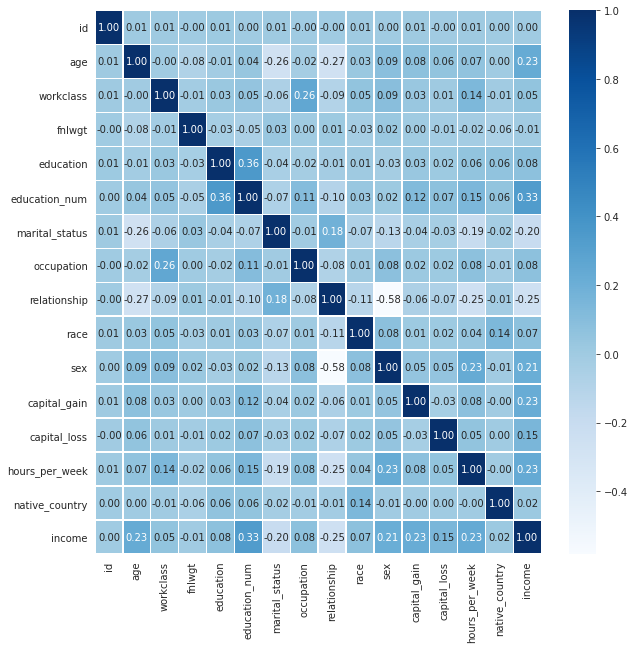

In [65]:
# 상관관계 heatmap

plt.figure(figsize=(10,10))
sns.heatmap(data = df_num.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

# age, education_num, marital_status, relationship, sex, capital_gain, capital_loss, hours_per_week 가 연관있어 보인다.

# Data Processing (step.01)

In [66]:
# id 컬럼 제외
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [67]:
# education 컬럼은 education_num과 1대1 매칭 >> education 컬럼 제외
train.drop(['education'], axis=1, inplace=True)
test.drop(['education'], axis=1, inplace=True)

In [69]:
# fnlwgt 컬럼은 사후 층화 가중치로서, 한 표본이 몇 개를 대표하는지 의미. / 제외
# 'https://m.blog.naver.com/stat833/221747335785'
train.drop(['fnlwgt'], axis=1, inplace=True)
test.drop(['fnlwgt'], axis=1, inplace=True)

In [70]:
# income column >> 50K 기준으로 대소 비교 변수 파생 (True/False)
train['is_income_over_50K'] = train['income']=='>50K'
print(train.shape)
train.head()

(26049, 14)


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,is_income_over_50K
0,40,Private,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K,True
1,17,Private,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,<=50K,False
2,18,Private,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,<=50K,False
3,21,Private,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,<=50K,False
4,24,Private,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,<=50K,False


###  one-hot 인코딩

In [8]:
## test data

dtypes = df_t.dtypes
encoders = {}
for column in df_t.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_t[column])
        encoders[column] = encoder
df_num_t = df_t.copy()

for column in encoders.keys():
    encoder = encoders[column]
    df_num_t[column] = encoder.transform(df_t[column])
    
print(df_num_t.shape)
df_num_t.tail(3)

(6512, 15)


,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
6509,6509,39,4,409189,4,3,2,8,0,4,1,0,0,40,26
6510,6510,35,4,180342,11,9,2,3,0,4,1,0,0,40,39
6511,6511,28,4,156819,11,9,0,6,4,4,0,0,0,36,39


# Data Processing (step.02)

### Capital_gain & Capital_loss

In [10]:
# train
df['capital_gain_bool'] = df['capital_gain'] > 0
df['capital_loss_bool'] = df['capital_loss'] > 0
print(df.shape);  
display(df[['capital_loss', 'capital_loss_bool']].head())

# test
df_t['capital_gain_bool'] = df_t['capital_gain'] > 0
df_t['capital_loss_bool'] = df_t['capital_loss'] > 0
print(df_t.shape)
display(df_t[['capital_loss', 'capital_loss_bool']].head())

(26049, 19)


,capital_loss,capital_loss_bool
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False


(6512, 17)


,capital_loss,capital_loss_bool
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False


# EDA (step.03)

## 03-1. sex + marital_status + education_num

In [11]:
# 3. 남성이면서, 기혼자면서, 14년 이상 공부한 사람들
df['Male_married_14y_edu'] =  (df['sex'] == 'Male') & (df['marital_status'] == 'Married-civ-spouse') & (df['education_num'] >= 14)
print(df.shape)
df[['sex', 'marital_status','education_num','Male_married_14y_edu']].head()

(26049, 20)


,sex,marital_status,education_num,Male_married_14y_edu
0,Male,Married-civ-spouse,9,False
1,Male,Never-married,5,False
2,Male,Never-married,10,False
3,Female,Never-married,10,False
4,Female,Never-married,10,False


In [12]:
# test
df_t['Male_married_14y_edu'] =  (df_t['sex'] == 'Male') & (df_t['marital_status'] == 'Married-civ-spouse') & (df_t['education_num'] >= 14)
print(df.shape)
df_t[['sex', 'marital_status','education_num','Male_married_14y_edu']].head()

(26049, 20)


,sex,marital_status,education_num,Male_married_14y_edu
0,Female,Never-married,10,False
1,Male,Married-civ-spouse,9,False
2,Male,Never-married,10,False
3,Male,Married-civ-spouse,11,False
4,Male,Married-civ-spouse,16,True


In [13]:
# 1,235 명 중 968명이 연 소득 5만 달러 이상입니다.
df[['Male_married_14y_edu','is_income_over_50K']].value_counts()

Male_married_14y_edu  is_income_over_50K
False                 False                 19477
                      True                   5337
True                  True                    968
                      False                   267
dtype: int64

## 03-2. occupation + marital_status + workclass

In [14]:
# occupation
df['ceo_prof_m'] = ((df['occupation'] == 'Exec-managerial') | (df['occupation'] == 'Prof-specialty')) & (df['marital_status'] == 'Married-civ-spouse')
print(df.shape)
df[['occupation', 'marital_status', 'ceo_prof_m']].head()

(26049, 21)


,occupation,marital_status,ceo_prof_m
0,Sales,Married-civ-spouse,False
1,Machine-op-inspct,Never-married,False
2,Other-service,Never-married,False
3,Prof-specialty,Never-married,False
4,Adm-clerical,Never-married,False


In [15]:
# test
df_t['ceo_prof_m'] = ((df_t['occupation'] == 'Exec-managerial') | (df_t['occupation'] == 'Prof-specialty')) & (df_t['marital_status'] == 'Married-civ-spouse')
print(df_t.shape)
df_t[['occupation', 'marital_status', 'ceo_prof_m']].head()

(6512, 19)


,occupation,marital_status,ceo_prof_m
0,Adm-clerical,Never-married,False
1,Exec-managerial,Married-civ-spouse,True
2,Handlers-cleaners,Never-married,False
3,Exec-managerial,Married-civ-spouse,True
4,Prof-specialty,Married-civ-spouse,True


In [16]:
df[['ceo_prof_m','is_income_over_50K']].value_counts()

ceo_prof_m  is_income_over_50K
False       False                 18638
            True                   3763
True        True                   2542
            False                  1106
dtype: int64

# PREPROCESSING (step.04)

In [17]:
# 1 age
# 나이를 구간화(Binning) 합니다.
df['age_bin'] = pd.qcut(df['age'], 10, labels = False)

print(df.shape)
df[['age', 'age_bin']]

(26049, 22)


,age,age_bin
0,40,5
1,17,0
2,18,0
3,21,0
4,24,1
...,...,...
26044,57,8
26045,23,1
26046,78,9
26047,26,1


In [18]:
# test
df_t['age_bin'] = pd.qcut(df_t['age'], 10, labels = False)

print(df_t.shape)
df_t[['age', 'age_bin']]

(6512, 20)


,age,age_bin
0,28,2
1,40,5
2,20,0
3,40,5
4,37,4
...,...,...
6507,35,4
6508,41,5
6509,39,5
6510,35,4


In [19]:
# 2. hours_per_week:
# 정규화
df['hours_per_week_log'] = np.log(df['hours_per_week'] + 1)

# test
df_t['hours_per_week_log'] = np.log(df_t['hours_per_week'] + 1)

/home/theo/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/theo/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='hours_per_week_log', ylabel='Density'>

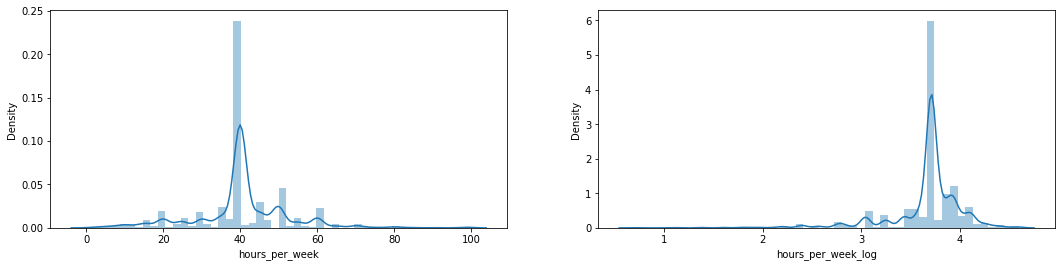

In [20]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)


sns.distplot(df["hours_per_week"], ax=ax1)
sns.distplot(df["hours_per_week_log"], ax=ax2)

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
# one hot 인코딩

dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
df_num = df.copy()

for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])
    
print(df_num.shape)
df_num.tail(10)

(26049, 23)


,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,...,hours_per_week,native_country,income,is_income_over_50K,capital_gain_bool,capital_loss_bool,Male_married_14y_edu,ceo_prof_m,age_bin,hours_per_week_log
26039,26039,52,1,129177,11,9,0,1,1,4,...,40,38,0,False,False,False,False,False,8,3.713572
26040,26040,39,4,30269,8,11,0,12,4,4,...,40,38,0,False,False,False,False,False,5,3.713572
26041,26041,44,4,103233,9,13,4,1,4,2,...,40,38,0,False,False,False,False,False,6,3.713572
26042,26042,48,6,191389,15,10,5,12,4,4,...,50,38,0,False,False,False,False,False,7,3.931826
26043,26043,34,6,234960,9,13,2,10,0,2,...,48,38,1,True,False,True,False,True,4,3.891820
26044,26044,57,4,250201,1,7,2,8,0,4,...,52,38,0,False,False,False,False,False,8,3.970292
26045,26045,23,4,238092,9,13,4,10,3,4,...,40,38,0,False,False,False,False,False,1,3.713572
26046,26046,78,0,165694,12,14,6,0,1,4,...,15,38,0,False,False,False,False,False,9,2.772589
26047,26047,26,6,151626,11,9,4,10,3,2,...,40,38,0,False,False,False,False,False,1,3.713572
26048,26048,20,0,99891,15,10,4,0,3,4,...,30,38,0,False,False,False,False,False,0,3.433987


In [22]:
# test one hot 인코딩

dtypes = df_t.dtypes
encoders = {}
for column in df_t.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df_t[column])
        encoders[column] = encoder
df_num_t = df_t.copy()

for column in encoders.keys():
    encoder = encoders[column]
    df_num_t[column] = encoder.transform(df_t[column])
    
print(df_num_t.shape)
df_num_t.tail(10)

(6512, 21)


,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,...,capital_gain,capital_loss,hours_per_week,native_country,capital_gain_bool,capital_loss_bool,Male_married_14y_edu,ceo_prof_m,age_bin,hours_per_week_log
6502,6502,25,4,198587,15,10,4,13,1,2,...,2174,0,50,39,True,False,False,False,1,3.931826
6503,6503,70,6,124449,12,14,2,4,0,4,...,0,2246,8,39,False,True,True,True,9,2.197225
6504,6504,41,4,163322,1,7,0,4,4,4,...,0,0,36,39,False,False,False,False,5,3.610918
6505,6505,55,4,171015,15,10,4,1,3,4,...,0,0,36,39,False,False,False,False,8,3.610918
6506,6506,56,4,112840,11,9,2,4,0,4,...,0,0,55,39,False,False,False,True,8,4.025352
6507,6507,35,4,61343,9,13,2,12,0,4,...,0,0,40,39,False,False,False,False,4,3.713572
6508,6508,41,5,32185,9,13,2,13,0,4,...,0,0,40,39,False,False,False,False,5,3.713572
6509,6509,39,4,409189,4,3,2,8,0,4,...,0,0,40,26,False,False,False,False,5,3.713572
6510,6510,35,4,180342,11,9,2,3,0,4,...,0,0,40,39,False,False,False,False,4,3.713572
6511,6511,28,4,156819,11,9,0,6,4,4,...,0,0,36,39,False,False,False,False,2,3.610918


# Feature Engineering (step.05)

In [23]:
# encode
to_encode = ['workclass', 'fnlwgt', 'education_num',
       'marital_status', 'occupation', 'relationship',
       'capital_gain', 'capital_loss','native_country']

encoded = pd.get_dummies(df[to_encode])
encoded_t = pd.get_dummies(df_t[to_encode])
encoded['native_country_Holand-Netherlands'] = 0

In [24]:
df.columns

Index(['id', 'age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income', 'is_income_over_50K', 'capital_gain_bool',
       'capital_loss_bool', 'Male_married_14y_edu', 'ceo_prof_m', 'age_bin',
       'hours_per_week_log'],
      dtype='object')

In [25]:
features = ['age_bin', 'hours_per_week_log']
target = 'is_income_over_50K'

In [26]:
preprocessed = df[features]
preprocessed_t = df_t[features]

In [27]:
print(preprocessed.shape)
print(preprocessed_t.shape)

(26049, 2)
(6512, 2)


In [28]:
X = pd.concat([preprocessed, encoded], axis=1)
test = pd.concat([preprocessed_t, encoded_t], axis=1)
y = df[target]

print(X.shape)
print(test.shape)
print(y.shape)

(26049, 85)
(6512, 85)
(26049,)


# Model Tuning & Evaluation (step.06)

# Model Tuning & Evaluation (step.06-1)

In [39]:
# 데이터 분석 라이브러리
import numpy as np
import pandas as pd

# 시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#from plotnine import *

# 모델링 라이브러리
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

# 기타 라이브러리
import random
import gc
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
sns.set_style("whitegrid")

In [72]:
path = '/home/theo/aiffel/data_represent/data/kakr-4th-competition/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

print(train.shape)
print(test.shape)

(26049, 16)
(6512, 15)


In [73]:
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

In [74]:
y = train['income'] != '<=50K'
X = train.drop(['income'], axis=1)

In [75]:
y = train['income'] != '<=50K'
X = train.drop(['income'], axis=1)

# 라벨 인코더 생성
LE_encoder = OrdinalEncoder(list(X.columns))

# train, test 데이터에 인코딩 적용
X = LE_encoder.fit_transform(X, y)
test = LE_encoder.transform(test)

In [78]:
X

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,40,1,168538,1,9,1,1,1,1,1,0,0,60,1
1,17,1,101626,2,5,2,2,2,1,1,0,0,20,1
2,18,1,353358,3,10,2,3,2,1,1,0,0,16,1
3,21,1,151158,3,10,2,4,2,1,2,0,0,25,1
4,24,1,122234,3,10,2,5,3,2,2,0,0,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,57,1,250201,5,7,1,3,1,1,1,0,0,52,1
26045,23,1,238092,4,13,2,4,2,1,1,0,0,40,1
26046,78,3,165694,12,14,6,7,3,1,2,0,0,15,1
26047,26,4,151626,1,9,2,4,2,2,2,0,0,40,1


In [44]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

columns = X.columns
splits = folds.split(X, y)
y_preds = np.zeros(test.shape[0])

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

In [45]:
model = LGBMClassifier(objective='binary',
                       learning_rate = 0.08,
                       max_depth = -1,
                       num_leaves = 50,
                       min_data_in_leaf = 30,
                       boosting_type = 'gbdt',
                       verbosity = -1,
                       verbose=400, 
                       random_state=91)


for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold: ', fold_n+1)
    X_t, X_v = X.iloc[train_index], X.iloc[valid_index]
    y_t, y_v = y.iloc[train_index], y.iloc[valid_index]

    evals = [(X_t, y_t), (X_v, y_v)]
    model.fit(X_t, y_t, eval_metric='f1', eval_set=evals, verbose=True)
    
    feature_importances[f'fold_{fold_n + 1}'] = model.feature_importances_
        
    y_preds += model.predict(test).astype(int) / NFOLDS
    
    del X_t, X_v, y_t, y_v
    gc.collect()

Fold:  1
[LightGBM] [Warning] verbosity is set=-1, verbose=400 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[1]	training's binary_logloss: 0.517592	valid_1's binary_logloss: 0.514858
[2]	training's binary_logloss: 0.488875	valid_1's binary_logloss: 0.486995
[3]	training's binary_logloss: 0.465205	valid_1's binary_logloss: 0.464168
[4]	training's binary_logloss: 0.445425	valid_1's binary_logloss: 0.4454
[5]	training's binary_logloss: 0.428362	valid_1's binary_logloss: 0.429167
[6]	training's binary_logloss: 0.413489	valid_1's binary_logloss: 0.414962
[7]	training's binary_logloss: 0.400093	valid_1's binary_logloss: 0.402712
[8]	training's binary_logloss: 0.388565	valid_1's binary_logloss: 0.392048
[9]	training's binary_logloss: 0.378292	valid_1's binary_logloss: 0.382309
[10]	training's binary_logloss: 0.368933	valid_1's binary_logloss: 0.37343
[11]	training's binary

[38]	training's binary_logloss: 0.271435	valid_1's binary_logloss: 0.291292
[39]	training's binary_logloss: 0.270176	valid_1's binary_logloss: 0.290545
[40]	training's binary_logloss: 0.268892	valid_1's binary_logloss: 0.289772
[41]	training's binary_logloss: 0.267751	valid_1's binary_logloss: 0.289395
[42]	training's binary_logloss: 0.266652	valid_1's binary_logloss: 0.288793
[43]	training's binary_logloss: 0.265547	valid_1's binary_logloss: 0.288373
[44]	training's binary_logloss: 0.264461	valid_1's binary_logloss: 0.287892
[45]	training's binary_logloss: 0.263378	valid_1's binary_logloss: 0.28708
[46]	training's binary_logloss: 0.261963	valid_1's binary_logloss: 0.286184
[47]	training's binary_logloss: 0.260974	valid_1's binary_logloss: 0.28556
[48]	training's binary_logloss: 0.260067	valid_1's binary_logloss: 0.285129
[49]	training's binary_logloss: 0.258902	valid_1's binary_logloss: 0.28454
[50]	training's binary_logloss: 0.257965	valid_1's binary_logloss: 0.283896
[51]	training's

[96]	training's binary_logloss: 0.230494	valid_1's binary_logloss: 0.267163
[97]	training's binary_logloss: 0.229967	valid_1's binary_logloss: 0.266893
[98]	training's binary_logloss: 0.229487	valid_1's binary_logloss: 0.266802
[99]	training's binary_logloss: 0.229029	valid_1's binary_logloss: 0.266783
[100]	training's binary_logloss: 0.22854	valid_1's binary_logloss: 0.266829
Fold:  4
[LightGBM] [Warning] verbosity is set=-1, verbose=400 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[1]	training's binary_logloss: 0.517059	valid_1's binary_logloss: 0.51619
[2]	training's binary_logloss: 0.48807	valid_1's binary_logloss: 0.489236
[3]	training's binary_logloss: 0.464037	valid_1's binary_logloss: 0.467128
[4]	training's binary_logloss: 0.444085	valid_1's binary_logloss: 0.448743
[5]	training's binary_logloss: 0.426686	valid_1's binary_logloss: 0.432931
[6]	training's bi

[41]	training's binary_logloss: 0.265226	valid_1's binary_logloss: 0.299416
[42]	training's binary_logloss: 0.264033	valid_1's binary_logloss: 0.298634
[43]	training's binary_logloss: 0.26265	valid_1's binary_logloss: 0.297896
[44]	training's binary_logloss: 0.261529	valid_1's binary_logloss: 0.297357
[45]	training's binary_logloss: 0.260333	valid_1's binary_logloss: 0.296765
[46]	training's binary_logloss: 0.259133	valid_1's binary_logloss: 0.296166
[47]	training's binary_logloss: 0.258169	valid_1's binary_logloss: 0.295727
[48]	training's binary_logloss: 0.257098	valid_1's binary_logloss: 0.295307
[49]	training's binary_logloss: 0.256169	valid_1's binary_logloss: 0.295098
[50]	training's binary_logloss: 0.255051	valid_1's binary_logloss: 0.294517
[51]	training's binary_logloss: 0.254167	valid_1's binary_logloss: 0.294044
[52]	training's binary_logloss: 0.253434	valid_1's binary_logloss: 0.293889
[53]	training's binary_logloss: 0.252682	valid_1's binary_logloss: 0.293939
[54]	training

In [46]:
model = LGBMClassifier(objective='binary',
                       verbose=400, 
                       random_state=91)


for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Fold: ', fold_n+1)
    X_t, X_v = X.iloc[train_index], X.iloc[valid_index]
    y_t, y_v = y.iloc[train_index], y.iloc[valid_index]

    evals = [(X_t, y_t), (X_v, y_v)]
    model.fit(X_t, y_t, eval_metric='f1', eval_set=evals, verbose=True)
    
    feature_importances[f'fold_{fold_n + 1}'] = model.feature_importances_
        
    y_preds += model.predict(test).astype(int) / NFOLDS
    
    del X_t, X_v, y_t, y_v
    gc.collect()

In [47]:
sample_submission['prediction'] = y_preds

for ix, row in sample_submission.iterrows():
    if row['prediction'] > 0.5:
        sample_submission.loc[ix, 'prediction'] = 1
    else:
        sample_submission.loc[ix, 'prediction'] = 0

sample_submission = sample_submission.astype({"prediction": int})
sample_submission.to_csv('/home/theo/aiffel/data_represent/data/kakr-4th-competition/submission_11_07_2.csv', index=False)

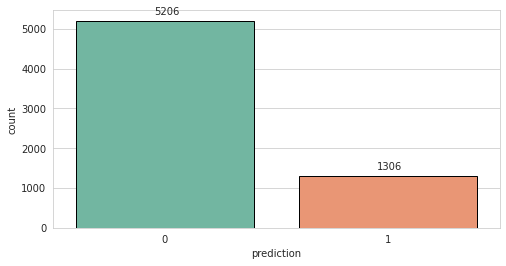

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
col = 'prediction'
value_counts = sample_submission[col].value_counts()
sns.countplot(x=col, data=sample_submission, palette="Set2", edgecolor='black', order = value_counts.index)

for i, v in value_counts.reset_index().iterrows():
    ax.text(i-0.05, v[col]+150 , v[col])